# Packages

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    r2_score, 
    mean_absolute_percentage_error
)
from catboost import CatBoostRegressor, Pool
import catboost as cb
from xgboost import XGBRegressor
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor
from typing import Union, List
from scipy.stats import mstats
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
import time

import pickle
from datetime import datetime
import re
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from fuzzywuzzy import fuzz
import joblib
from google.cloud import storage
from google.cloud import bigquery
# Connection to Bigquery
client = bigquery.Client(project='prj-prod-dataplatform')

import tempfile
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Settings in this Notebook
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", None)





# Constants

In [2]:
# Constants

BUCKET_NAME = "prod-asia-southeast1-tonik-aiml-workspace"
CLOUDPATH = "Monthly_Income_Estimation/Income_Estimation_Models"
CLOUDPATH_TARGET = "Monthly_Income_Estimation/Target_Encoded_Artifacts"
DATATYPE = "Step2"
LOCALPATH = "/home/jupyter/Models/Income_Estimation_Models/Income_Estimation_Model/"
LOCALPATHSRC = "/home/jupyter/Models/Income_Estimation_Models/Income_Estimation_Model/"
LOCALPATHARTIFACTS = "/home/jupyter/Models/Income_Estimation_Models/Income_Estimation_Model/"
MODELNAME = "Beta2WithOutApp"
VERSIONNAME = "1_0"
PRODUCT_TYPE = 'SIL_Quick'
CURRENT_DATE = datetime.now().strftime("%Y%m%d")

## read_csv_from_gcs

In [3]:
def read_csv_from_gcs(project_id, bucket_name, file_path):
  """Reads a CSV file from a GCS bucket into a pandas DataFrame.

  Args:
    project_id: The Google Cloud project ID.
    bucket_name: The name of the GCS bucket.
    file_path: The path to the CSV file within the bucket.

  Returns:
    A pandas DataFrame containing the CSV data.
  """

  storage_client = storage.Client(project=project_id)
  bucket = storage_client.bucket(bucket_name)
  blob = bucket.blob(file_path)

  with blob.open('r') as f:
    df = pd.read_csv(f)

  return df


## Beta2 Without App

In [4]:
# gs://prod-asia-southeast1-tonik-aiml-workspace/Monthly_Income_Estimation/IncomeEstimation_Beta1V3.1/20250115_Beta1V3.1_Step2_dataStep2.csv

data_filename = "20250207_Beta2WithOutApp_SIL_Quick1_0_data2.csv"
project_id = 'prj-prod-dataplatform'
bucket_name = BUCKET_NAME
file_path = f'{CLOUDPATH}/{data_filename}'

df = read_csv_from_gcs(project_id, bucket_name, file_path)
print(f"The shape of the {CLOUDPATH}/{data_filename} is :\t {df.shape}")



The shape of the Monthly_Income_Estimation/Income_Estimation_Models/20250207_Beta2WithOutApp_SIL_Quick1_0_data2.csv is :	 (103926, 41)


In [5]:
df.columns.values

array(['cust_id', 'digitalLoanAccountId', 'loanAccountNumber',
       'onboarding_datetime', 'email', 'age', 'Gender', 'onb_mobile_no',
       'loan_mobile_no', 'onb_mobile_Not_match_loan_mobile',
       'flag_alternate_mobile_provided', 'loan_purpose', 'source_funds',
       'employment_type', 'nature_of_work', 'industry_description',
       'loan_company_name', 'maritalStatus', 'dependentsCount',
       'loan_education_level', 'loan_ref_type1', 'loan_ref_type2',
       'loan_province', 'loan_city', 'loan_barangay', 'loan_postalcode',
       'loan_geolocation', 'loan_product_type', 'osversion_v2',
       'clean_version', 'loan_brand', 'loan_vas_opted_flag',
       'Dataselection', 'place_of_birth', 'loan_docType', 'onb_latitude',
       'onb_longitude', 'loan_type', 'loan_docNumber', 'daystoapply',
       'loan_monthly_income'], dtype=object)

In [6]:
sq = """select digitalLoanAccountId, date(decision_date) decision_date from `risk_credit_mis.loan_master_table`;"""
dfloan = client.query(sq).to_dataframe(progress_bar_type = 'tqdm')

df = df.merge(dfloan, on = 'digitalLoanAccountId', how = 'inner')
df.shape

Job ID baf308c0-9b4c-4059-8fd2-8ca40145a1e9 successfully executed: 100%|██████████|
Downloading: 100%|██████████|


(103926, 42)

In [7]:
df.isnull().sum()

cust_id                                 0
digitalLoanAccountId                    0
loanAccountNumber                       0
onboarding_datetime                     0
email                                   0
age                                     0
Gender                                  0
onb_mobile_no                           0
loan_mobile_no                          0
onb_mobile_Not_match_loan_mobile        0
flag_alternate_mobile_provided          0
loan_purpose                            0
source_funds                         1790
employment_type                         0
nature_of_work                      72148
industry_description                15280
loan_company_name                   21584
maritalStatus                           0
dependentsCount                     37523
loan_education_level                 8497
loan_ref_type1                       8497
loan_ref_type2                       8497
loan_province                           0
loan_city                         

# Custom Transformers

## DateTimeFeatureTransformer

In [8]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class DateTimeFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.time_bins = [-1, 3, 9, 18, 24]
        self.time_labels = ['12am-3am', '4am-8am', '9am-6pm', '7pm-12am']
        self.feature_names = [
            'Onboarding_time_of_day',
            'Onboarding_time_of_day_cat',
            'Onboarding_mon_of_year',
            'Onboarding_week_of_month',
            'Onboarding_day_of_week',
            'Onboarding_Is_Weekend'
        ]
        self.output_format = "default"  # Default output format

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if isinstance(X, pd.Series):
            X = pd.DataFrame(X)

        # Check if 'onboarding_datetime' column is available
        if 'onboarding_datetime' not in X.columns:
            return X.to_numpy() if self.output_format != "pandas" else X

        # Convert to datetime if not already
        X_copy = X.copy()
        X_copy['onboarding_datetime'] = pd.to_datetime(X_copy['onboarding_datetime'])

        # Extract features
        features = pd.DataFrame()

        # Time of day
        features['Onboarding_time_of_day'] = X_copy['onboarding_datetime'].dt.hour
        features['Onboarding_time_of_day_cat'] = pd.cut(
            features['Onboarding_time_of_day'],
            bins=self.time_bins,
            labels=self.time_labels,
            right=False
        )

        # Month and week features
        features['Onboarding_mon_of_year'] = X_copy['onboarding_datetime'].dt.month
        features['Onboarding_week_of_month'] = ((X_copy['onboarding_datetime'].dt.day - 1) // 7 + 1)
        features['Onboarding_week_of_month'] = features['Onboarding_week_of_month'].apply(lambda x: f"Wk{x}")

        # Day of week features
        features['Onboarding_day_of_week'] = X_copy['onboarding_datetime'].dt.day_name()
        features['Onboarding_Is_Weekend'] = features['Onboarding_day_of_week'].apply(
            lambda x: 'Weekend' if x in ['Sunday', 'Saturday'] else 'Weekday'
        )

        # Return output based on the configured format
        if self.output_format == "pandas":
            return features
        else:
            return features.to_numpy()

    def get_feature_names_out(self, input_features=None):
        return self.feature_names

    def set_output(self, transform="default"):
        """
        Set the output format of the transformer.
        """
        self.output_format = transform
        return self

## TelecomProviderTransformer

In [9]:
class TelecomProviderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.output_format = "default"  # Default output format

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['onboard_mobile_initials'] = X['onb_mobile_no'].astype(str).str[-10:].str[:3]

        X['onboard_telconame'] = np.where(X['onboard_mobile_initials'].isin(['904', '905', '906', '915', '916', '917', '926', '927', '935', '936', '937', '945', '952', '953', '954', '955', '956', '957', '958', '959', '965', '966', '967', '975', '976', '977', '978', '979', '995', '996', '997', '817', '917', '925']), 'Globe',
                                    np.where(X['onboard_mobile_initials'].isin(['813', '900', '907', '908', '909', '910', '911', '912', '913', '914', '918', '919', '920', '921', '928', '929', '930', '938', '939', '940', '946', '947', '948', '949', '950', '951', '960', '961', '963', '964', '968', '969', '970', '971', '980', '981', '982', '985', '989', '998', '999', '922', '923', '924', '925', '931', '932', '933', '934', '941', '942', '943', '944', '962', '972', '973', '974']), 'Smart',
                                        np.where(X['onboard_mobile_initials'].isin(['991', '992', '993', '994', '895', '896', '897', '898']), 'DITO',  'Other'  )))

        # Return output based on the configured format
        if self.output_format == "pandas":
            return X[['onboard_telconame']]
        else:
            return X[['onboard_telconame']].to_numpy()

    def get_feature_names_out(self, input_features=None):
        return ['onboard_telconame']

    def set_output(self, transform="default"):
        """
        Set the output format of the transformer.
        """
        self.output_format = transform
        return self

## FuzzyMatchTransformer

In [10]:
class FuzzyMatchTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, col1, col2, threshold=50):
        self.col1 = col1
        self.col2 = col2
        self.threshold = threshold
        self.output_format = "default"  # Default output format

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Ensure the columns are strings and lowercase
        X[[self.col1, self.col2]] = X[[self.col1, self.col2]].astype(str).apply(lambda x: x.str.lower())

        # Calculate fuzzy similarity and create a list of flags based on the threshold
        similarity_flags = X.apply(
            lambda row: 1 if fuzz.ratio(row[self.col1], row[self.col2]) >= self.threshold else 0,
            axis=1
        ).tolist()

        # Return as a DataFrame to be compatible with ColumnTransformer
        result = pd.DataFrame(similarity_flags, columns=[f'diff_in_{self.col1}_{self.col2}_flag'])

        # Return output based on the configured format
        if self.output_format == "pandas":
            return result
        else:
            return result.to_numpy()

    def get_feature_names_out(self, input_features=None):
        return [f'diff_in_{self.col1}_{self.col2}_flag']

    def set_output(self, transform="default"):
        """
        Set the output format of the transformer.
        """
        self.output_format = transform
        return self

## DocumentTypeOSVersionTransformer

In [11]:
class DocumentTypeOSVersionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.output_format = "default"  # Default output format

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()

        # Document Type Categorization
        X['docType_category'] = np.where(
            X['onb_document_type'].str.contains('Driving License', na=False, case=False), 'Driving License',
            np.where(
                X['onb_document_type'].str.contains('UMID Card', na=False, case=False), 'UMID Card',
                np.where(
                    X['onb_document_type'].str.contains('ePassport|Passport', na=False, case=False), 'Passport',
                    np.where(
                        X['onb_document_type'].str.contains('Postal Id Card', na=False, case=False), 'Postal ID Card',
                        np.where(
                            X['onb_document_type'].str.contains('Social Security Card', na=False, case=False), 'Social Security Card',
                            np.where(
                                X['onb_document_type'].str.contains('Professional Id Card', na=False, case=False), 'Professional ID Card',
                                np.where(
                                    X['onb_document_type'].str.contains('Voter Card|Voting Card', na=False, case=False), 'Voter Card',
                                    np.where(
                                        X['onb_document_type'].str.contains('PhilID|National ID', na=False, case=False), 'National ID',
                                        'Others'
                                    ))))))))

        # OS Version Categorization
        X['devicevrs_Type'] = np.where(X['osversion_v2'].str.startswith('android'), 'android',
                                 np.where(X['osversion_v2'].str.startswith('ios'), 'ios', 'other'))

        # Return output based on the configured format
        if self.output_format == "pandas":
            return X[['docType_category', 'devicevrs_Type']]
        else:
            return X[['docType_category', 'devicevrs_Type']].to_numpy()

    def get_feature_names_out(self, input_features=None):
        return ['docType_category', 'devicevrs_Type']

    def set_output(self, transform="default"):
        """
        Set the output format of the transformer.
        """
        self.output_format = transform
        return self

## FuzzyNameEmailMatcher

In [12]:
class FuzzyNameEmailMatcher(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=80):
        self.threshold = threshold
        self.output_format = "default"  # Default output format

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['flg_name_&_email_match'] = X.apply(self._fuzzy_match_name_email, axis=1)

        # Return output based on the configured format
        if self.output_format == "pandas":
            return X[['flg_name_&_email_match']]
        else:
            return X[['flg_name_&_email_match']].to_numpy()

    def _fuzzy_match_name_email(self, row):
        first_name = row['first_name']
        middle_name = row['middle_name'] if pd.notna(row['middle_name']) else ''  # Handle NaN
        last_name = row['last_name']
        email = row['email']

        # Extract the local part of the email (before @)
        email_local = email.split('@')[0].lower()

        # Check similarity using fuzzy matching
        first_name_match = fuzz.partial_ratio(first_name.lower(), email_local) >= self.threshold
        middle_name_match = fuzz.partial_ratio(middle_name.lower(), email_local) >= self.threshold if middle_name else False
        last_name_match = fuzz.partial_ratio(last_name.lower(), email_local) >= self.threshold

        # If any of the parts matches, return 1, else 0
        if first_name_match or middle_name_match or last_name_match:
            return 1
        else:
            return 0

    def get_feature_names_out(self, input_features=None):
        return ['flg_name_&_email_match']

    def set_output(self, transform="default"):
        """
        Set the output format of the transformer.
        """
        self.output_format = transform
        return self

## EmailFeatureTransformer

In [13]:
class EmailFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.domain_freq = None
        self.output_format = "default"  # Default output format

    def fit(self, X, y=None):
        if 'email' in X.columns:
            X['email'].str.lower()
            domains = X['email'].apply(lambda x: x.split('@')[1])
            self.domain_freq = domains.value_counts().to_dict()
        return self

    def transform(self, X, y=None):
        if 'email' not in X.columns:
            return pd.DataFrame()

        X_transformed = X.copy()
        X_transformed['domain'] = X_transformed['email'].apply(lambda x: x.split('@')[1])
        X_transformed['tld'] = X_transformed['domain'].apply(lambda x: x.split('.')[-1])

        # Return output based on the configured format
        if self.output_format == "pandas":
            return X_transformed[['domain', 'tld']]
        else:
            return X_transformed[['domain', 'tld']].to_numpy()

    def get_feature_names_out(self, input_features=None):
        return ['domain', 'tld']

    def set_output(self, transform="default"):
        """
        Set the output format of the transformer.
        """
        self.output_format = transform
        return self

## VersionCategorizer

In [14]:
class VersionCategorizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.output_format = "default"  # Default output format

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['osversionType'] = X.apply(self._categorize, axis=1)

        # Return output based on the configured format
        if self.output_format == "pandas":
            return X[['osversionType']]
        else:
            return X[['osversionType']].to_numpy()

    def _categorize(self, row):
        os_version = str(row['osversion_v2']).lower()
        clean_version = row['clean_version']

        if 'android' in os_version:
            if clean_version >= 15:
                return '5-Pioneer'
            elif clean_version == 14:
                return '4-Innovator'
            elif clean_version == 7:
                return '3-ComfortSeeker'
            elif clean_version in [13, 12, 11, 10, 6]:
                return '2-Voyager'
        elif 'ios' in os_version:
            if clean_version >= 18:
                return '5-Pioneer'
            elif clean_version in [17, 16]:
                return '3-ComfortSeeker'
            elif clean_version in [15, 14]:
                return '2-Voyager'
        return '1-Nomad'

    def get_feature_names_out(self, input_features=None):
        return ['osversionType']

    def set_output(self, transform="default"):
        """
        Set the output format of the transformer.
        """
        self.output_format = transform
        return self

## NatureOfWorkTransformer

In [15]:
class NatureOfWorkTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=50):
        self.threshold = threshold
        self.mapping = None
        self.column_present = False
        self.output_format = "default"  # Default output format

    def fit(self, X, y=None):
        if 'nature_of_work' in X.columns:
            self.column_present = True
            value_counts = X['nature_of_work'].value_counts()
            self.mapping = {work: 'Others' if count < self.threshold else work 
                          for work, count in value_counts.items()}
        return self

    def transform(self, X, y=None):
        if not self.column_present or 'nature_of_work' not in X.columns:
            return pd.DataFrame()

        X_transformed = X.copy()
        X_transformed['nature_of_work_grouped'] = X_transformed['nature_of_work'].map(self.mapping)

        # Return output based on the configured format
        if self.output_format == "pandas":
            return X_transformed[['nature_of_work_grouped']]
        else:
            return X_transformed[['nature_of_work_grouped']].to_numpy()

    def get_feature_names_out(self, input_features=None):
        return ['nature_of_work_grouped']

    def set_output(self, transform="default"):
        """
        Set the output format of the transformer.
        """
        self.output_format = transform
        return self

## TextClusteringTransformer

In [16]:
class TextClusteringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, col1, col2, n_clusters=6, vector_size=50, window=3, min_count=1, sg=0):
        self.col1 = col1
        self.col2 = col2
        self.n_clusters = n_clusters
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.sg = sg
        self.model = None
        self.kmeans = None
        self.output_format = "default"  # Default output format

    def clean_word(self, word):
        word = str(word).replace('/', ' ')
        return re.sub(r'[^\w\s]', '', word)

    def remove_extra_spaces(self, sentence):
        return re.sub(r'\s+', ' ', str(sentence)).strip()

    def get_vector(self, sentence, model, vector_size=50):
        words = sentence.split()
        vec = np.zeros(vector_size)
        count = 0
        for word in words:
            if word in model.wv:
                vec += model.wv[word]
                count += 1
        if count > 0:
            vec /= count
        return vec

    def fit(self, X, y=None):
        X = X.copy()
        X[self.col1] = X[self.col1].str.lower()
        X[self.col2] = X[self.col2].str.lower()

        X[self.col1] = X[self.col1].fillna('missing')
        X[self.col2] = X[self.col2].fillna('missing')

        X['company_and_industry'] = X[self.col1] + ' ' + X[self.col2]
        X['company_and_industry'] = X['company_and_industry'].apply(
            lambda x: self.remove_extra_spaces(' '.join([self.clean_word(word) for word in str(x).split()])))

        sentences = X['company_and_industry'].apply(lambda x: x.split())
        self.model = Word2Vec(sentences, vector_size=self.vector_size, window=self.window, 
                            min_count=self.min_count, sg=self.sg)

        X_vectors = np.vstack(X['company_and_industry'].apply(
            lambda x: self.get_vector(x, self.model, self.vector_size)))

        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
        self.kmeans.fit(X_vectors)

        return self

    def transform(self, X):
        X = X.copy()
        X[self.col1] = X[self.col1].str.lower()
        X[self.col2] = X[self.col2].str.lower()

        X[self.col1] = X[self.col1].fillna('missing')
        X[self.col2] = X[self.col2].fillna('missing')

        X['company_and_industry'] = X[self.col1] + ' ' + X[self.col2]
        X['company_and_industry'] = X['company_and_industry'].apply(
            lambda x: self.remove_extra_spaces(' '.join([self.clean_word(word) for word in str(x).split()])))

        X_vectors = np.vstack(X['company_and_industry'].apply(
            lambda x: self.get_vector(x, self.model, self.vector_size)))

        clusters = self.kmeans.predict(X_vectors)

        # Only return cluster and company_and_industry columns
        result_df = pd.DataFrame({
            'cluster': clusters,
            'company_and_industry': X['company_and_industry']
        })

        # Return output based on the configured format
        if self.output_format == "pandas":
            return result_df
        else:
            return result_df.to_numpy()

    def get_feature_names_out(self, input_features=None):
        return ['cluster', 'company_and_industry']

    def set_output(self, transform="default"):
        """
        Set the output format of the transformer.
        """
        self.output_format = transform
        return self

## Create Preprocessor

In [17]:
def create_preprocessor(df):
    # Existing transformers
    email_transformer = Pipeline([
        ('email_features', EmailFeatureTransformer())
    ])

    version_transformer = Pipeline([
        ('version_cat', VersionCategorizer())
    ])

    work_transformer = Pipeline([
        ('work_features', NatureOfWorkTransformer(threshold=50))
    ])

    text_transformer = Pipeline([
        ('text_cluster', TextClusteringTransformer(
            col1='loan_company_name', 
            col2='industry_description', 
            n_clusters=6
        ))
    ])
    
    datetime_transformer = Pipeline([
        ('datetime_features', DateTimeFeatureTransformer())
    ])
    
    telecom_transformer = Pipeline([
        ('telecom_provider', TelecomProviderTransformer())
    ])
    
    fuzzy_match_transformer = Pipeline([
        ('fuzzy_match', FuzzyMatchTransformer(col1='place_of_birth', col2='onb_city', threshold=50))
    ])
    
    document_os_transformer = Pipeline([
        ('document_os_features', DocumentTypeOSVersionTransformer())
    ])
    
    fuzzy_name_email_transformer = Pipeline([
        ('fuzzy_name_email_match', FuzzyNameEmailMatcher(threshold=80))
    ])
    
    transformers = []

    if ('osversion_v2' in df.columns) and ('clean_version' in df.columns):
        transformers.append(('version', version_transformer, ['osversion_v2', 'clean_version']))

    if 'email' in df.columns:
        transformers.append(('email', email_transformer, ['email']))

    if 'onboarding_datetime' in df.columns:
        transformers.append(('datetime', datetime_transformer, ['onboarding_datetime']))
        
    if 'nature_of_work' in df.columns:
        transformers.append(('work', work_transformer, ['nature_of_work']))
        
    if ('loan_company_name' in df.columns) and ('industry_description' in df.columns):
        transformers.append(('text', text_transformer, ['loan_company_name', 'industry_description']))
        
    if 'onb_mobile_no' in df.columns:
        transformers.append(('telecom', telecom_transformer, ['onb_mobile_no']))
    
    if ('place_of_birth' in df.columns) and ('onb_city' in df.columns):
        transformers.append(('fuzzy_match', fuzzy_match_transformer, ['place_of_birth', 'onb_city']))
        
    if ('onb_document_type' in df.columns) and ('osversion_v2' in df.columns):
        transformers.append(('document_os', document_os_transformer, ['onb_document_type', 'osversion_v2']))
        
    if ('first_name' in df.columns) and ('middle_name' in df.columns) and ('last_name' in df.columns) and ('email' in df.columns):
        transformers.append(('fuzzy_name_email', fuzzy_name_email_transformer, ['first_name','middle_name', 'last_name', 'email']))
    
    preprocessor = ColumnTransformer(
        transformers=transformers,
        remainder='drop'
    )

    # Replace missing values with 'Missing'
    categorical_imputer = SimpleImputer(strategy='constant', fill_value='missing')

    # Create the final pipeline
    final_pipeline = Pipeline([
        ('categorical_imputer', categorical_imputer),
        ('preprocessor', preprocessor)
    ])

    # Set the output to pandas DataFrame
    final_pipeline.set_output(transform="pandas")

    return final_pipeline

# Test the entire transformes

## Test

In [18]:
# X_train, X_test, y_train, y_test, numerical_cols, categorical_cols = prepare_data_cat_model1(dfmerged, 'loan_monthly_income')

# Assuming dfmerged is your original DataFrame
preprocessor = create_preprocessor(df)

# Fit and transform the data
df_transformed = preprocessor.fit_transform(df)

# Inspect the results
print("Transformed dataframe shape:", df_transformed.shape)
print("\nColumns in transformed dataframe:")
print(df_transformed.columns)

# Display the first few rows of the transformed dataframe
print("\nTransformed dataframe head:")
# Now combine the original dfmerged with df_transformed
# First, get the list of columns that were used in transformations to avoid duplicates
transformed_source_cols = ['email', 'osversion_v2', 'clean_version', 'nature_of_work', 
                           'onb_mobile_no']

# Drop the source columns from dfmerged to avoid duplicates
dfmerged_filtered = df.drop(columns=transformed_source_cols)

# Combine the filtered original dataframe with the transformed features
final_df = pd.concat([dfmerged_filtered, df_transformed], axis=1)
final_df.head()

Transformed dataframe shape: (103926, 13)

Columns in transformed dataframe:
Index(['version__osversionType', 'email__domain', 'email__tld',
       'datetime__Onboarding_time_of_day',
       'datetime__Onboarding_time_of_day_cat',
       'datetime__Onboarding_mon_of_year',
       'datetime__Onboarding_week_of_month',
       'datetime__Onboarding_day_of_week', 'datetime__Onboarding_Is_Weekend',
       'work__nature_of_work_grouped', 'text__cluster',
       'text__company_and_industry', 'telecom__onboard_telconame'],
      dtype='object')

Transformed dataframe head:


,cust_id,digitalLoanAccountId,loanAccountNumber,onboarding_datetime,age,Gender,loan_mobile_no,onb_mobile_Not_match_loan_mobile,flag_alternate_mobile_provided,loan_purpose,source_funds,employment_type,industry_description,loan_company_name,maritalStatus,dependentsCount,loan_education_level,loan_ref_type1,loan_ref_type2,loan_province,loan_city,loan_barangay,loan_postalcode,loan_geolocation,loan_product_type,loan_brand,loan_vas_opted_flag,Dataselection,place_of_birth,loan_docType,onb_latitude,onb_longitude,loan_type,loan_docNumber,daystoapply,loan_monthly_income,decision_date,version__osversionType,email__domain,email__tld,datetime__Onboarding_time_of_day,datetime__Onboarding_time_of_day_cat,datetime__Onboarding_mon_of_year,datetime__Onboarding_week_of_month,datetime__Onboarding_day_of_week,datetime__Onboarding_Is_Weekend,work__nature_of_work_grouped,text__cluster,text__company_and_industry,telecom__onboard_telconame
0,3000673,fbaf9634-fb1a-44d1-923d-ecb0fcc8cc73,60830006730018,2024-11-05 12:28:56,57,F,639912756540,0,1,"Televisions,Stereo set, Soundbar, Audio equipment",Remittance,Remittance Beneficiary,NaN,NaN,Married,1,College Undergraduate,Child,Sibling,METRO MANILA,QUEZON CITY,DEL MONTE,1105,14.6226977 | 120.9991971,Appliance,vivo,1,OOT_NOV_24,Quezon City,Philippines - Id Card (2020),14.605446,120.993140,SIL ZERO,7142061275178573,0,30000.0,2024-11-05,4-Innovator,gmail.com,com,12,9am-6pm,11,Wk1,Tuesday,Weekday,missing,4,missing missing,DITO
1,2992498,b60ad5cf-8e43-4abb-8634-b5f76b1ddfc7,60829924980011,2024-11-02 12:39:12,27,F,639684386136,0,0,Televisions,Remittance,Remittance Beneficiary,NaN,NaN,Live-in Partner,1,College Graduate,Parent,Parent,METRO MANILA,QUEZON CITY,SAN BARTOLOME,1116,14.6685552 | 120.9672054,Appliance,Infinix,1,OOT_NOV_24,SAMAR,Philippines - Id Card (2020),14.667675,120.962404,SIL-Instore,4098301904736248,0,20000.0,2024-11-02,2-Voyager,gmail.com,com,12,9am-6pm,11,Wk1,Saturday,Weekend,missing,4,missing missing,Smart
2,2995291,450a71b8-7525-43c1-9f3f-c13cf99da185,60829952910011,2024-11-03 12:36:21,47,M,639977048764,0,1,Televisions,Salary,Employed - Private Employee,Others,Expert Security Agency,Live-in Partner,1,High School Graduate,Co-worker,Spouse,METRO MANILA,QUEZON CITY,PAYATAS,1119,null | null,Appliance,Redmi,1,OOT_NOV_24,Pangasinan,Philippines - UMID Card (2010),NaN,NaN,SIL-Instore,011110366125,0,25000.0,2024-11-03,2-Voyager,gmail.com,com,12,9am-6pm,11,Wk1,Sunday,Weekend,missing,1,expert security agency others,Globe
3,3004416,110077f3-9456-4d51-9402-fb21d77647d1,60830044160019,2024-11-06 18:50:53,29,F,639265337860,0,1,"Mobile Phones,Accessories or Peripherals",Salary,Employed - Private Employee,Others,leekie enterprises inc,Single,NaN,College Undergraduate,Sibling,Sibling,METRO MANILA,QUEZON CITY,NOVALICHES PROPER,1121,null | null,Appliance,Apple,1,OOT_NOV_24,Quezon city,Philippines - UMID Card (2016),NaN,NaN,SIL-Instore,011168348331,0,28000.0,2024-11-06,5-Pioneer,gmail.com,com,18,7pm-12am,11,Wk1,Wednesday,Weekday,Licensed Professional - Others,1,leekie enterprises inc others,Globe
4,2442887,8eacc41d-eff9-4bb9-9759-df754dc8d2d5,60824428870031,2024-03-27 17:46:15,21,M,639927421785,0,0,"Dining set, Chairs or Tables,Bed frames or Cribs",Income from Business,Self-Employed/Private Practice,Others,Mangiboa Store,Single,NaN,High School Graduate,Friend,Parent,METRO MANILA,QUEZON CITY,NAGKAISANG NAYON,1125,14.5764508 | 121.033381,Appliance,OPPO,1,OOT_NOV_24,Don Carlos Bukidnon,Philippines - Id Card (2020),14.575968,121.034455,SIL-Instore,PCN: 5802-3813-2471-9578,222,15000.0,2024-11-04,4-Innovator,gmail.com,com,17,9am-6pm,3,Wk4,Wednesday,Weekday,missing,2,mangiboa store others,DITO


In [19]:
final_df.rename(columns = {'version__osversionType':'ln_os_versiontype', 
                           'work__nature_of_work_grouped':'ln_nature_of_work',
                          'maritalStatus':'ln_marital_status',
                           'loan_product_type':'ln_loan_type',
                           'loan_education_level':'ln_education_level',
                           'industry_description':'ln_Industry_desc',
                           'employment_type': 'ln_Employment_type',
                           'age': 'ln_age',
                           'loan_city': 'ln_city',
                           'loan_purpose': 'ln_purpose_desc',
                           'loan_docType': 'ln_docType',
                           'Gender': 'ln_gender',
                           'dependentsCount': 'ln_dependent_count',
                           'loan_postalcode':'ln_postalcode',
                           'source_funds': 'ln_source_funds',
                           'loan_geolocation': 'ln_geolocation',
                           'place_of_birth': 'ln_place_of_birth',
                           'loan_monthly_income': 'ln_monthly_income',
                           'onboarding_datetime':'onb_datetime',
                           'version__osversionType': 'ln_osversion_type',
                           'email__domain': 'ln_email_domain',
                           'email__tld': 'ln_email_tld',
                           'loan_brand':'ln_brand'
                            }, inplace = True)

final_df.columns.values

array(['cust_id', 'digitalLoanAccountId', 'loanAccountNumber',
       'onb_datetime', 'ln_age', 'ln_gender', 'loan_mobile_no',
       'onb_mobile_Not_match_loan_mobile',
       'flag_alternate_mobile_provided', 'ln_purpose_desc',
       'ln_source_funds', 'ln_Employment_type', 'ln_Industry_desc',
       'loan_company_name', 'ln_marital_status', 'ln_dependent_count',
       'ln_education_level', 'loan_ref_type1', 'loan_ref_type2',
       'loan_province', 'ln_city', 'loan_barangay', 'ln_postalcode',
       'ln_geolocation', 'ln_loan_type', 'ln_brand',
       'loan_vas_opted_flag', 'Dataselection', 'ln_place_of_birth',
       'ln_docType', 'onb_latitude', 'onb_longitude', 'loan_type',
       'loan_docNumber', 'daystoapply', 'ln_monthly_income',
       'decision_date', 'ln_osversion_type', 'ln_email_domain',
       'ln_email_tld', 'datetime__Onboarding_time_of_day',
       'datetime__Onboarding_time_of_day_cat',
       'datetime__Onboarding_mon_of_year',
       'datetime__Onboarding_week_o

In [20]:
df = final_df.copy()

In [ ]:
print(f"df['decision_date'].max()

In [21]:
import joblib

# Load the state file
state = joblib.load('/home/jupyter/Models/Income_Estimation_Models/Income_Estimation_Model/Beta2WithOutApp_SIL_Quick_1_0_model_good_customer_state_top18SHAP_Step2.joblib')

# Extract the model (since your feature count is 18)
model = state['model_top18SHAP']

# Extract numerical and categorical columns
numerical_cols = state['numerical_cols_top18SHAP']
categorical_cols = state['categorical_cols_top18SHAP']

# You can also verify the shapes of your training and test data
X_train_shape = state['X_train_shape']
X_test_shape = state['X_test_shape']

# Print to verify the extracted information
print("Model type:", type(model))
print("\nNumerical columns:", numerical_cols)
print("\nCategorical columns:", categorical_cols)
print("\nTraining data shape:", X_train_shape)
print("\nTest data shape:", X_test_shape)

Model type: <class 'catboost.core.CatBoostRegressor'>

Numerical columns: ['encoded_company_name_group', 'ln_age', 'ln_postalcode']

Categorical columns: ['ln_Employment_type', 'ln_Industry_desc', 'ln_brand', 'ln_city', 'ln_dependent_count', 'ln_docType', 'ln_education_level', 'ln_email_domain', 'ln_gender', 'ln_loan_type', 'ln_nature_of_work', 'ln_osversion_type', 'ln_purpose_desc', 'ln_source_funds', 'loan_barangay']

Training data shape: (61584, 18)

Test data shape: (12749, 18)


In [22]:
# def Custom_Catboost_Model(df, target_variable, threshold=0.8, columns_to_exclude=None):
#     """
#     Custom CatBoost model implementation with data preparation and visualization
    
#     Parameters:
#     -----------
#     df : pandas.DataFrame
#         Input dataframe
#     target_variable : str
#         Name of the target variable column
#     threshold : float, optional
#         Threshold for multicollinearity detection (default: 0.8)
#     columns_to_exclude : list, optional
#         List of columns to exclude from the analysis
#     """
#     import pandas as pd
#     import numpy as np
#     import matplotlib.pyplot as plt
#     import seaborn as sns
#     from catboost import CatBoostRegressor
#     from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
    
#     # Set default columns to exclude if none provided
#     if columns_to_exclude is None:
#         columns_to_exclude = ['cust_id', 'digitalLoanAccountId', 'onboarding_datetime', 'loanAccountNumber']

#     def plot_actual_vs_predicted(y_true, y_pred, title='Actual vs Predicted Values'):
#         plt.figure(figsize=(10, 6))
#         plt.scatter(y_true, y_pred, alpha=0.5)
#         plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
#         plt.xlabel('Actual Values')
#         plt.ylabel('Predicted Values')
#         plt.title(title)
#         plt.tight_layout()
#         plt.show()

#     def plot_residuals_hist(y_true, y_pred, title='Residual Histogram Plot'):
#         y_true_float = np.array(y_true, dtype=float)
#         y_pred_float = np.array(y_pred, dtype=float)
#         residuals = y_true_float - y_pred_float
#         plt.figure(figsize=(10, 6))
#         sns.histplot(residuals, kde=True)
#         plt.title('Residual Histogram')
#         plt.xlabel('Residuals')
#         plt.ylabel('Frequency')
#         plt.show()

#     def plot_lift_chart(y_test, y_pred, n_bins=10):
#         results = pd.DataFrame({
#             'Actual': y_test,
#             'Predicted': y_pred
#         })
#         results['Decile'] = pd.qcut(results['Predicted'], q=n_bins, labels=False)
#         lift_chart_data = results.groupby('Decile').agg(
#             Avg_Predicted=('Predicted', 'mean'),
#             Avg_Actual=('Actual', 'mean')
#         ).reset_index()
        
#         plt.figure(figsize=(10, 6))
#         plt.plot(lift_chart_data['Avg_Predicted'], label='Predicted', marker='o')
#         plt.plot(lift_chart_data['Avg_Actual'], label='Actual', marker='s')
#         plt.title("Lift Chart")
#         plt.xlabel(f"Decile (1-{n_bins})")
#         plt.ylabel("Average Value")
#         plt.legend()
#         plt.grid()
#         plt.show()

#     def plot_gain_chart(y_test, y_pred, n_bins=10):
#         results = pd.DataFrame({
#             'Actual': y_test,
#             'Predicted': y_pred
#         })
#         results = results.sort_values(by='Predicted', ascending=False).reset_index(drop=True)
#         results['Cumulative_Actual'] = results['Actual'].cumsum()
#         results['Cumulative_Predicted'] = results['Predicted'].cumsum()
#         results['Cumulative_Actual_Percent'] = results['Cumulative_Actual'] / results['Actual'].sum() * 100
#         results['Cumulative_Predicted_Percent'] = results['Cumulative_Predicted'] / results['Predicted'].sum() * 100
#         results['Percentage_of_Data'] = np.linspace(1 / len(results), 1, len(results)) * 100
        
#         plt.figure(figsize=(10, 6))
#         plt.plot(results['Percentage_of_Data'], results['Cumulative_Predicted_Percent'], label='Predicted', marker='o')
#         plt.plot(results['Percentage_of_Data'], results['Cumulative_Actual_Percent'], label='Actual', marker='s')
#         plt.title("Gain Chart")
#         plt.xlabel("Percentage of Data")
#         plt.ylabel("Cumulative Percentage")
#         plt.legend()
#         plt.grid()
#         plt.show()

#     def categorize_columns(df, target_variable):
#         numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
#         numerical_cols = [col for col in numerical_cols if col != target_variable]
#         categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
#         categorical_cols = [col for col in categorical_cols if col != target_variable]
#         return numerical_cols, categorical_cols

#     def remove_multicollinearity(df, numerical_cols, threshold=0.8):
#         corr_matrix = df[numerical_cols].corr().abs()
#         # Sort columns to ensure consistent ordering
#         corr_matrix = corr_matrix.sort_index(axis=0).sort_index(axis=1)
#         upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
#         # Sort to ensure consistent column dropping
#         to_drop = sorted([column for column in upper_tri.columns if any(upper_tri[column] > threshold)])
#         reduced_cols = sorted([col for col in numerical_cols if col not in to_drop])
#         return reduced_cols, to_drop
    
#     def load_dataframe_from_gcs(bucket_name, blob_name):
#         """Loads a DataFrame from a pickle file stored in Google Cloud Storage.

#         Args:
#             bucket_name: The name of the GCS bucket.
#             blob_name: The name of the blob (file) within the bucket.

#         Returns:
#             A pandas DataFrame, or None if an error occurs.
#         """
#         try:
#             storage_client = storage.Client()
#             bucket = storage_client.bucket(bucket_name)
#             blob = bucket.blob(blob_name)

#             # Download the blob to a BytesIO object
#             blob_as_bytes = blob.download_as_bytes()

#             # Load the DataFrame from the BytesIO object
#             df = pickle.loads(blob_as_bytes)

#             # Check if loaded object is a pandas DataFrame
#             if not isinstance(df, pd.DataFrame):
#                 raise TypeError(f"Object loaded from pickle file is not a pandas DataFrame. It is a {type(df)}.")

#             return df

#         except Exception as e:
#             print(f"Error loading DataFrame: {e}")
#             return None
        
#     def reduce_doc_type(doc_type):
#         # Define mappings from specific document types to common categories
#         doc_type_mappings = {
#             'Id Card': 'ID Card',
#             'UMID Card': 'UMID Card',
#             'Driving License': 'Driving License',
#             'ePassport': 'Passport',
#             'Professional Id Card': 'Professional ID Card',
#             'Social Security Card': 'Social Security Card',
#             'Postal Id Card': 'Postal ID Card',
#             'Professional Driving License': 'Driving License',
#             'Passport': 'Passport'
#         }

#         # Iterate through the mappings and return the common category if a match is found
#         for key, value in doc_type_mappings.items():
#             if key in doc_type:
#                 return value

#         # Return 'Other' if no match is found
#         return 'Other'
    
#     from google.cloud import storage
#     import joblib
#     import tempfile
#     import os

#     def load_dataframe_from_gcs_joblib(bucket_name, blob_name):
#         """
#         Load a DataFrame from Google Cloud Storage using joblib

#         Parameters:
#         bucket_name (str): Name of the GCS bucket
#         blob_name (str): Path to the blob in GCS

#         Returns:
#         DataFrame: The loaded DataFrame
#         """
#         # Create a client
#         client = storage.Client()

#         # Get bucket and blob
#         bucket = client.bucket(bucket_name)
#         blob = bucket.blob(blob_name)

#         # Create a temporary file
#         with tempfile.NamedTemporaryFile(delete=False) as temp_file:
#             # Download the blob to the temporary file
#             blob.download_to_filename(temp_file.name)

#             # Load the data using joblib
#             data = joblib.load(temp_file.name)

#         # Clean up the temporary file
#         os.unlink(temp_file.name)

#         return data

#     # # Example usage:
#     # bucket_name = "prod-asia-southeast1-tonik-aiml-workspace"
#     # blob_name = "Monthly_Income_Estimation/Data/Beta1_Model/Supporting_Data/Artifacts/20250106_data_GoodCustomer_Beta2.pkl"
#     # dfencodeddata = load_dataframe_from_gcs(bucket_name, blob_name)
#     # print(dfencodeddata.columns)
#     #gs://prod-asia-southeast1-tonik-aiml-workspace/Monthly_Income_Estimation/Target_Encoded_Artifacts/CompanyNameTargetEncoderfull.joblib
    

    
#     bucket_name = BUCKET_NAME
#     blob_name = "Monthly_Income_Estimation/Target_Encoded_Artifacts/companytrgencode.joblib"
#     # blob_name = f"{CLOUDPATH}/companytrgencode.joblib"
#     # print(f"Company Encoder downloaded from {CLOUDPATH}")
#     print(f"Data downloaded from {blob_name}")

#     dfencodeddata = load_dataframe_from_gcs_joblib(bucket_name, blob_name)
#     print(dfencodeddata.columns)
    
#     # Modified prepare_data_cat_model1 function
#     def prepare_data_cat_model1(df, target_variable):
#         # Sort the input DataFrame by index
#         df = df.sort_index().copy()
        
#             # Ensure consistent data types
#         for col in df.select_dtypes(include=['float64']).columns:
#             df[col] = df[col].astype('float64')
#         for col in df.select_dtypes(include=['int64']).columns:
#             df[col] = df[col].astype('int64')
        
#         # Store digitalLoanAccountId before dropping
#         train_loan_ids = df[df['Dataselection'] == 'Train']['digitalLoanAccountId']
#         test_loan_ids = df[df['Dataselection'] == 'Test']['digitalLoanAccountId']
        
#         # [Rest of the data preparation code remains the same until the return statement]
        
#         if 'ln_docType' in df.columns:
#             df['ln_docType'] = df['ln_docType'].apply(reduce_doc_type)

# #         if 'de_onboard_document_type' in df.columns:
# #             df['de_onboard_document_type'] = df['de_onboard_document_type'].apply(reduce_doc_type)
        
#         dfcn = dfencodeddata[['loan_company_name', 'freq_encodedcompanyName', 'target_encodedcompanyName', 'encoded_company_name_group']].copy()
#         print(f"The shape of dfcn before duplicate drop is:\t {dfcn.shape}")
#         dfcn = dfcn.drop_duplicates()
#         print(f"The shape of dfcn is:\t {dfcn.shape}")
#         dfcn['freq_encodedcompanyName'] = dfcn['freq_encodedcompanyName'].fillna(1)
#         dfcn['target_encodedcompanyName'] = dfcn['target_encodedcompanyName'].fillna(dfencodeddata['global_mean'])
#         dfcn['encoded_company_name_group'] = dfcn['encoded_company_name_group'].fillna(dfencodeddata['global_mean'])
#         df = df.merge(dfcn, left_on ='loan_company_name', right_on ='loan_company_name', how='left')
#         df.drop(columns = ['loan_company_name'], inplace = True)
        
#         df_train = df[df['Dataselection'] == 'Train']
#         df_test = df[df['Dataselection'] == 'Test']
#         df_train = df_train.drop(columns=['Dataselection'])
#         df_test = df_test.drop(columns=['Dataselection'])
        
#         df_train = df_train.sort_index()
#         df_test = df_test.sort_index()
        
#         print(f"The shape of df_train is:\t{df_train.shape}")
        
#         # Remove specified columns except digitalLoanAccountId
#         # temp_exclude = [col for col in columns_to_exclude if col != 'digitalLoanAccountId']
#         temp_exclude = [col for col in columns_to_exclude]
#         print(temp_exclude)
#         df_train = df_train.drop(columns=temp_exclude, errors='ignore')
#         df_test = df_test.drop(columns=temp_exclude, errors='ignore')
        
#         numerical_cols, categorical_cols = categorize_columns(df_train, target_variable)
#         # Sort the numerical cols and Categorical cols
#         numerical_cols = sorted(numerical_cols)
#         categorical_cols = sorted(categorical_cols)
#         numerical_cols, dropped_cols = remove_multicollinearity(df_train, numerical_cols)
#         print("Dropped columns due to multicollinearity:", dropped_cols)
        
#         X_train = df_train[numerical_cols + categorical_cols]
#         y_train = df_train[target_variable]
#         X_test = df_test[numerical_cols + categorical_cols]
#         y_test = df_test[target_variable]
        
#         X_train = X_train.sort_index()
#         X_test = X_test.sort_index()
        
#         for col in categorical_cols:
#             X_train[col] = X_train[col].fillna('missing').astype(str)
#             X_test[col] = X_test[col].fillna('missing').astype(str)
        
#         for col in numerical_cols:
#             X_train[col] = pd.to_numeric(X_train[col], errors='coerce').fillna(0)
#             X_test[col] = pd.to_numeric(X_test[col], errors='coerce').fillna(0)
        
#         return X_train, X_test, y_train, y_test, numerical_cols, categorical_cols, train_loan_ids, test_loan_ids

#     def evaluate_model(y_true, y_pred):
#         mae = mean_absolute_error(y_true, y_pred)
#         mse = mean_squared_error(y_true, y_pred)
#         rmse = np.sqrt(mse)
#         r2 = r2_score(y_true, y_pred)
#         mape = mean_absolute_percentage_error(y_true, y_pred)
#         print("Model Performance Metrics:")
#         print(f"Mean Absolute Error (MAE): {mae:.2f}")
#         print(f"Mean Squared Error (MSE): {mse:.2f}")
#         print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
#         print(f"R-squared (R2): {r2:.4f}")
#         print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
#         return mae, mse, rmse, r2, mape

#     def get_feature_importance(model, numerical_cols, categorical_cols):
#         all_features = numerical_cols + categorical_cols
#         feature_importance = model.feature_importances_
#         feature_importance_df = pd.DataFrame({
#             'feature': all_features,
#             'importance': feature_importance
#         })
#         feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).reset_index(drop=True)
#         return feature_importance_df

#     # Main execution
#     print("Preparing data...")
#     X_train, X_test, y_train, y_test, numerical_cols, categorical_cols, train_loan_ids, test_loan_ids = prepare_data_cat_model1(
#         df, target_variable
#     )
    
#     print("\nTraining model...")
#     cat_features_indices = [X_train.columns.get_loc(col) for col in categorical_cols]
#     # model = CatBoostRegressor(
#     #     cat_features=cat_features_indices,
#     #     iterations=1000,
#     #     learning_rate=0.05,
#     #     l2_leaf_reg=8,
#     #     random_strength=1,
#     #     random_seed=42,
#     #     loss_function='MAE',
#     #     depth=8,
#     #     verbose=False
#     # )
    
#     # model = CatBoostRegressor(
#     #     cat_features=cat_features_indices,
#     #     iterations=1000,
#     #     learning_rate=0.05,
#     #     l2_leaf_reg=8,
#     #     random_seed=random_state,
#     #     # random_seed=42,  # Keep only this one
#     #     loss_function='MAE',
#     #     depth=8,
#     #     verbose=False,
#     #     bootstrap_type='No',
#     #     # bootstrap_type='Bernoulli',
#     #     subsample=0.8,
#     #     # random_state=42,  # Remove this
#     #     boosting_type='Plain',
#     #     thread_count=1,
#     #     train_dir='catboost_info',
#     #     min_data_in_leaf=1,
#     #     leaf_estimation_iterations=1
#     #     )
    
#     # Modify your CatBoostRegressor parameters:
#     # model = CatBoostRegressor(
#     #     cat_features=cat_features_indices,
#     #     iterations=1000,
#     #     learning_rate=0.05,
#     #     l2_leaf_reg=8,
#     #     random_seed=random_state,
#     #     loss_function='MAE',
#     #     depth=8,
#     #     verbose=False,
#     #     bootstrap_type='No',        # Change this
#     #     boosting_type='Plain',
#     #     thread_count=1,             # Add this
#     #     train_dir='catboost_info',  # Add this
#     #     leaf_estimation_iterations=1
#     # )
    
#     model = CatBoostRegressor(
#         cat_features=cat_features_indices,
#         iterations=1000,
#         learning_rate=0.05,
#         l2_leaf_reg=8,
#         random_seed=42,
#         loss_function='MAE',
#         depth=8,
#         verbose=False,
#         bootstrap_type='No',
#         boosting_type='Plain',
#         thread_count=1,
#         train_dir='catboost_info',
#         leaf_estimation_iterations=1,
#         has_time=False,           # Add this
#         allow_const_label=True,   # Add this
#         score_function='L2'       # Add this
#         )
#     model.fit(X_train, y_train)

#     print("\nMaking predictions...")
#     y_pred_train = model.predict(X_train)
#     y_pred_test = model.predict(X_test)

#     # Create result dataframes
#     train_result_df = pd.DataFrame({
#         'digitalLoanAccountId': train_loan_ids,
#         'actual_value': y_train,
#         'predicted_value': y_pred_train
#     })

#     test_result_df = pd.DataFrame({
#         'digitalLoanAccountId': test_loan_ids,
#         'actual_value': y_test,
#         'predicted_value': y_pred_test
#     })

#     # Combine train and test results
#     result_df = pd.concat([train_result_df, test_result_df], axis=0).reset_index(drop=True)

#     print("\nCalculating metrics...")
#     acc_train = model.score(X_train, y_train) * 100
#     acc_test = model.score(X_test, y_test) * 100
#     print(f'Training accuracy: {acc_train:.2f}%')
#     print(f'Test accuracy: {acc_test:.2f}%')

#     metrics = evaluate_model(y_test, y_pred_test)
#     feature_importance_df = get_feature_importance(model, numerical_cols, categorical_cols)
    
#     explainer = shap.Explainer(model)
#     shap_values = explainer(X_test)
    
#     print("\nGenerating plots...")
#     plot_actual_vs_predicted(y_test, y_pred_test)
#     plot_residuals_hist(y_test, y_pred_test)
#     plot_lift_chart(y_test, y_pred_test)
#     plot_gain_chart(y_test, y_pred_test)
    
#     print("\nTop 10 Most Important Features:")
#     print(feature_importance_df.head(20))
    
#     shap.plots.beeswarm(shap_values, max_display=20)
#     shap.plots.bar(shap_values, max_display=20)
    
#     shap_values_array = shap_values.values
#     shap_sum = np.abs(shap_values_array).mean(axis=0)
#     feature_importance_shap = pd.DataFrame(list(zip(X_test.columns, shap_sum)), columns=['feature', 'shap_importance'])
#     top_shap_features = feature_importance_shap.sort_values(by='shap_importance', ascending=False).head(20)

#     return {
#         'model': model,
#         'metrics': metrics,
#         'feature_importance': feature_importance_df,
#         'predictions': y_pred_test,
#         'X_train': X_train,
#         'X_test': X_test,
#         'y_train': y_train,
#         'y_test': y_test,
#         'numerical_cols': numerical_cols,
#         'categorical_cols': categorical_cols,
#         'top_ten_shap_features': top_shap_features,
#         'result_df': result_df  # Added result_df to the return dictionary
#     }

In [23]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from catboost import CatBoostRegressor
# import shap
# from datetime import datetime

# # Function to download a file from Google Cloud Storage
# def download_blob(bucket_name, source_blob_name, destination_file_name):
#     """Downloads a blob from the bucket."""
#     client = storage.Client()
#     bucket = client.bucket(bucket_name)
#     blob = bucket.blob(source_blob_name)
#     blob.download_to_filename(destination_file_name)
#     print(f"Downloaded {source_blob_name} to {destination_file_name}.")

# def analyze_feature_stability(df, model, feature_name='encoded_company_name_group', 
#                             date_column='decision_date', 
#                             numerical_cols=None, categorical_cols=None):
#     """
#     Analyze the stability of a specific feature's SHAP importance across different months.
    
#     Parameters:
#     -----------
#     df : pandas.DataFrame
#         Input dataframe containing the data
#     model : CatBoostRegressor
#         Trained CatBoost model
#     feature_name : str
#         Name of the feature to analyze
#     date_column : str
#         Name of the column containing dates
#     numerical_cols : list
#         List of numerical column names
#     categorical_cols : list
#         List of categorical column names
#     """
    
#     # Convert date column to datetime if it's not already
#     df[date_column] = pd.to_datetime(df[date_column])
    
#     # Extract month and year
#     df['month_year'] = df[date_column].dt.strftime('%Y-%m')
    
#     # Initialize SHAP explainer
#     explainer = shap.Explainer(model)
    
#     # Create storage for monthly SHAP values
#     monthly_importance = []
    
#     # Process each month separately
#     for month in sorted(df['month_year'].unique()):
#         print(f"Processing {month}...")
        
#         # Get data for this month
#         month_data = df[df['month_year'] == month].copy()
#         ENCODER = "gs://prod-asia-southeast1-tonik-aiml-workspace/Monthly_Income_Estimation/Target_Encoded_Artifacts/companytrgencode.joblib"
#         with tempfile.NamedTemporaryFile(delete=False, suffix=".joblib") as tmp_encoded_file:
#             if encoded_data_path.startswith("gs://"):
#                 bucket_name = encoded_data_path.split("/")[2]
#                 source_blob_name = "/".join(encoded_data_path.split("/")[3:])
#                 download_blob(bucket_name, source_blob_name, tmp_encoded_file.name)
#                 encoded_data_path = tmp_encoded_file.name
                
#             encoded_data = load(encoded_data_path)
        
#         # Extract company encoding data
#         company_encodings = encoded_data[['loan_company_name', 
#                                         'freq_encodedcompanyName', 
#                                         'target_encodedcompanyName', 
#                                         'encoded_company_name_group']].copy()
        
#         df_processed = month_data.copy()
        
#         df_processed = df_processed.drop_duplicates(keep='first')
#         # Fill NaN values with appropriate defaults
#         df_processed['freq_encodedcompanyName'] = df_processed['freq_encodedcompanyName'].fillna(0)
#         global_mean = encoded_data['target_encodedcompanyName'].mean()
#         df_processed['target_encodedcompanyName'] = df_processed['target_encodedcompanyName'].fillna(global_mean)
#         df_processed['encoded_company_name_group'] = df_processed['encoded_company_name_group'].fillna(global_mean)
        
#         df_processed.drop(columns=['loan_company_name', 'target_encodedcompanyName', 'freq_encodedcompanyName'], inplace = True)
        
#         month_data = df_processed.copy()  
        
            
        
            
            
        
        
#         # Prepare features
#         X_month = month_data[numerical_cols + categorical_cols]
        
#         # Handle categorical features
#         for col in categorical_cols:
#             X_month[col] = X_month[col].fillna('missing').astype(str)
            
#         # Handle numerical features
#         for col in numerical_cols:
#             X_month[col] = pd.to_numeric(X_month[col], errors='coerce').fillna(0)
        
#         # Calculate SHAP values for this month
#         shap_values = explainer(X_month)
        
#         # Get mean absolute SHAP value for our feature of interest
#         feature_idx = X_month.columns.get_loc(feature_name)
#         mean_shap = np.abs(shap_values.values[:, feature_idx]).mean()
        
#         # Store results
#         monthly_importance.append({
#             'month': month,
#             'shap_importance': mean_shap,
#             'sample_size': len(month_data)
#         })
    
#     # Convert to DataFrame
#     monthly_df = pd.DataFrame(monthly_importance)
    
#     # Create visualization
#     plt.figure(figsize=(15, 8))
    
#     # Create primary axis for SHAP importance
#     ax1 = plt.gca()
    
#     # Plot SHAP importance
#     line1 = ax1.plot(monthly_df['month'], monthly_df['shap_importance'], 
#                      marker='o', linewidth=2, color='blue', label='SHAP Importance')
#     ax1.set_xlabel('Month')
#     ax1.set_ylabel('SHAP Importance', color='blue')
#     ax1.tick_params(axis='y', labelcolor='blue')
    
#     # Rotate x-axis labels for better readability
#     plt.xticks(rotation=45)
    
#     # Create secondary axis for sample size
#     ax2 = ax1.twinx()
#     line2 = ax2.plot(monthly_df['month'], monthly_df['sample_size'], 
#                      marker='s', linewidth=2, color='red', linestyle='--', 
#                      label='Sample Size')
#     ax2.set_ylabel('Sample Size', color='red')
#     ax2.tick_params(axis='y', labelcolor='red')
    
#     # Add lines to legend
#     lines = line1 + line2
#     labels = [l.get_label() for l in lines]
#     ax1.legend(lines, labels, loc='upper right')
    
#     plt.title(f'Monthly Stability Analysis of {feature_name}')
#     plt.tight_layout()
#     plt.show()
    
#     # Calculate stability metrics
#     stability_metrics = {
#         'mean_importance': monthly_df['shap_importance'].mean(),
#         'std_importance': monthly_df['shap_importance'].std(),
#         'coefficient_of_variation': monthly_df['shap_importance'].std() / monthly_df['shap_importance'].mean(),
#         'min_importance': monthly_df['shap_importance'].min(),
#         'max_importance': monthly_df['shap_importance'].max(),
#         'range': monthly_df['shap_importance'].max() - monthly_df['shap_importance'].min()
#     }
    
#     print("\nStability Metrics:")
#     for metric, value in stability_metrics.items():
#         print(f"{metric}: {value:.2f}")
        
#     return monthly_df, stability_metrics

# # Example usage:
# # monthly_results, metrics = analyze_feature_stability(
# #     df=your_dataframe,
# #     model=your_loaded_model,
# #     feature_name='encoded_company_name_group',
# #     numerical_cols=your_numerical_cols,
# #     categorical_cols=your_categorical_cols
# # )

In [24]:
# # Load the state file that contains the model and columns information
# state = joblib.load('/home/jupyter/Models/Income_Estimation_Models/Income_Estimation_Model/Beta2WithOutApp_SIL_Quick_1_0_model_good_customer_state_top18SHAP_Step2.joblib')

# # Extract the model, numerical columns, and categorical columns from the state
# model = state['model_top18SHAP']  # Get the actual CatBoostRegressor object
# numerical_cols = state['numerical_cols_top18SHAP']
# categorical_cols = state['categorical_cols_top18SHAP']

# # Run the analysis
# monthly_results, stability_metrics = analyze_feature_stability(
#     df=df,  # Your original dataframe
#     model=model,
#     feature_name='encoded_company_name_group',
#     numerical_cols=numerical_cols,
#     categorical_cols=categorical_cols
# )

Downloaded Monthly_Income_Estimation/Target_Encoded_Artifacts/companytrgencode.joblib to /var/tmp/tmpodl_kn_c.joblib.
Processing 2023-07...
Processing 2023-08...
Processing 2023-09...
Processing 2023-10...
Processing 2023-11...
Processing 2023-12...
Processing 2024-01...
Processing 2024-02...
Processing 2024-03...
Processing 2024-04...
Processing 2024-05...
Processing 2024-06...
Processing 2024-07...
Processing 2024-08...
Processing 2024-09...
Processing 2024-10...
Processing 2024-11...


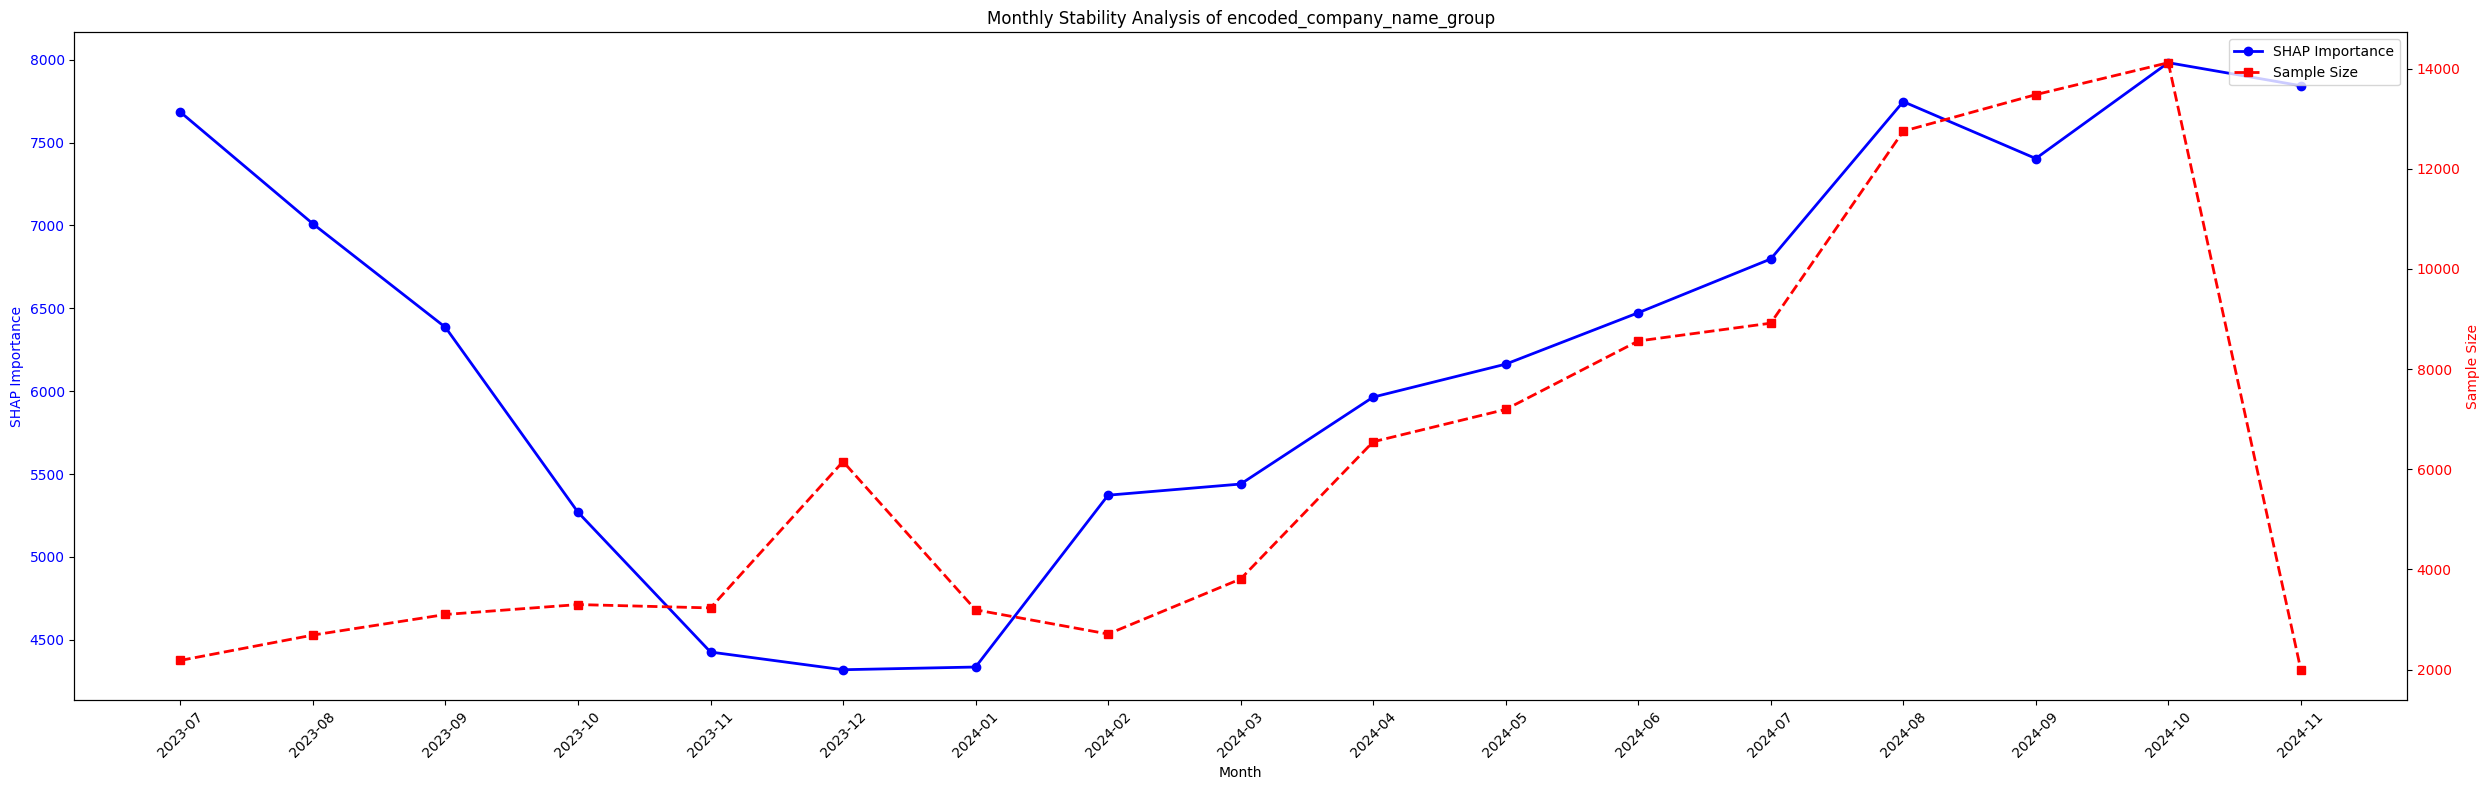


Stability Metrics:
mean_importance: 6271.52
std_importance: 1257.55
coefficient_of_variation: 0.20
min_importance: 4319.26
max_importance: 7982.23
range: 3662.97


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
import shap
from datetime import datetime
import tempfile
from google.cloud import storage
from joblib import load
import joblib

def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)
    print(f"Downloaded {source_blob_name} to {destination_file_name}.")

def analyze_feature_stability(df, model, feature_name='encoded_company_name_group', 
                            date_column='decision_date', 
                            numerical_cols=None, categorical_cols=None):
    """
    Analyze the stability of a specific feature's SHAP importance across different months.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing the data
    model : CatBoostRegressor
        Trained CatBoost model
    feature_name : str
        Name of the feature to analyze
    date_column : str
        Name of the column containing dates
    numerical_cols : list
        List of numerical column names
    categorical_cols : list
        List of categorical column names
    """
    
    # Convert date column to datetime if it's not already
    df[date_column] = pd.to_datetime(df[date_column])
    
    # Extract month and year
    df['month_year'] = df[date_column].dt.strftime('%Y-%m')
    
    # Initialize SHAP explainer
    explainer = shap.Explainer(model)
    
    # Create storage for monthly SHAP values
    monthly_importance = []
    
    # Define the encoder path
    encoded_data_path = "gs://prod-asia-southeast1-tonik-aiml-workspace/Monthly_Income_Estimation/Target_Encoded_Artifacts/companytrgencode.joblib"
    
    # Download and load encoded data once, outside the loop
    with tempfile.NamedTemporaryFile(delete=False, suffix=".joblib") as tmp_encoded_file:
        if encoded_data_path.startswith("gs://"):
            bucket_name = encoded_data_path.split("/")[2]
            source_blob_name = "/".join(encoded_data_path.split("/")[3:])
            download_blob(bucket_name, source_blob_name, tmp_encoded_file.name)
            encoded_data = load(tmp_encoded_file.name)
        else:
            encoded_data = load(encoded_data_path)
    
    # Process each month separately
    for month in sorted(df['month_year'].unique()):
        print(f"Processing {month}...")
        
        # Get data for this month
        month_data = df[df['month_year'] == month].copy()
        
        # Extract company encoding data
        company_encodings = encoded_data[['loan_company_name', 
                                        'freq_encodedcompanyName', 
                                        'target_encodedcompanyName', 
                                        'encoded_company_name_group']].copy()
        
        df_processed = month_data.copy()
        df_processed = df_processed.merge(company_encodings,
                                on='loan_company_name',
                                how='left')
        
        
        df_processed = df_processed.drop_duplicates(keep='first')
        
        # Fill NaN values with appropriate defaults
        df_processed['freq_encodedcompanyName'] = df_processed['freq_encodedcompanyName'].fillna(0)
        global_mean = encoded_data['target_encodedcompanyName'].mean()
        df_processed['target_encodedcompanyName'] = df_processed['target_encodedcompanyName'].fillna(global_mean)
        df_processed['encoded_company_name_group'] = df_processed['encoded_company_name_group'].fillna(global_mean)
        
        df_processed.drop(columns=['loan_company_name'], 
                         inplace=True, errors='ignore')
        
        month_data = df_processed.copy()
        
        # Prepare features
        X_month = month_data[numerical_cols + categorical_cols]
        
        # Handle categorical features
        for col in categorical_cols:
            X_month[col] = X_month[col].fillna('missing').astype(str)
            
        # Handle numerical features
        for col in numerical_cols:
            X_month[col] = pd.to_numeric(X_month[col], errors='coerce').fillna(0)
        
        # Calculate SHAP values for this month
        shap_values = explainer(X_month)
        
        # Get mean absolute SHAP value for our feature of interest
        feature_idx = X_month.columns.get_loc(feature_name)
        mean_shap = np.abs(shap_values.values[:, feature_idx]).mean()
        
        # Store results
        monthly_importance.append({
            'month': month,
            'shap_importance': mean_shap,
            'sample_size': len(month_data)
        })
    
    # Convert to DataFrame
    monthly_df = pd.DataFrame(monthly_importance)
    
    # Create visualization
    plt.figure(figsize=(25, 8))
    
    # Create primary axis for SHAP importance
    ax1 = plt.gca()
    
    # Plot SHAP importance
    line1 = ax1.plot(monthly_df['month'], monthly_df['shap_importance'], 
                     marker='o', linewidth=2, color='blue', label='SHAP Importance')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('SHAP Importance', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Create secondary axis for sample size
    ax2 = ax1.twinx()
    line2 = ax2.plot(monthly_df['month'], monthly_df['sample_size'], 
                     marker='s', linewidth=2, color='red', linestyle='--', 
                     label='Sample Size')
    ax2.set_ylabel('Sample Size', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Add lines to legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')
    
    plt.title(f'Monthly Stability Analysis of {feature_name}')
    plt.tight_layout()
    plt.show()
    
    # Calculate stability metrics
    stability_metrics = {
        'mean_importance': monthly_df['shap_importance'].mean(),
        'std_importance': monthly_df['shap_importance'].std(),
        'coefficient_of_variation': monthly_df['shap_importance'].std() / monthly_df['shap_importance'].mean(),
        'min_importance': monthly_df['shap_importance'].min(),
        'max_importance': monthly_df['shap_importance'].max(),
        'range': monthly_df['shap_importance'].max() - monthly_df['shap_importance'].min()
    }
    
    print("\nStability Metrics:")
    for metric, value in stability_metrics.items():
        print(f"{metric}: {value:.2f}")
        
    return monthly_df, stability_metrics

# Example usage:
if __name__ == "__main__":
    # Load the state file that contains the model and columns information
    state = joblib.load('/home/jupyter/Models/Income_Estimation_Models/Income_Estimation_Model/Beta2WithOutApp_SIL_Quick_1_0_model_good_customer_state_top18SHAP_Step2.joblib')

    # Extract the model, numerical columns, and categorical columns from the state
    model = state['model_top18SHAP']
    numerical_cols = state['numerical_cols_top18SHAP']
    categorical_cols = state['categorical_cols_top18SHAP']

    # Run the analysis (assuming df is your dataframe)
    monthly_results, stability_metrics = analyze_feature_stability(
        df=df,
        model=model,
        feature_name='encoded_company_name_group',
        numerical_cols=numerical_cols,
        categorical_cols=categorical_cols
    )

## Cummulative Stability Check

Downloaded Monthly_Income_Estimation/Target_Encoded_Artifacts/companytrgencode.joblib to /var/tmp/tmpo_chw8_x.joblib.
Processing data through 2023-07...
Processing data through 2023-08...
Processing data through 2023-09...
Processing data through 2023-10...
Processing data through 2023-11...
Processing data through 2023-12...
Processing data through 2024-01...
Processing data through 2024-02...
Processing data through 2024-03...
Processing data through 2024-04...
Processing data through 2024-05...
Processing data through 2024-06...
Processing data through 2024-07...
Processing data through 2024-08...
Processing data through 2024-09...
Processing data through 2024-10...
Processing data through 2024-11...


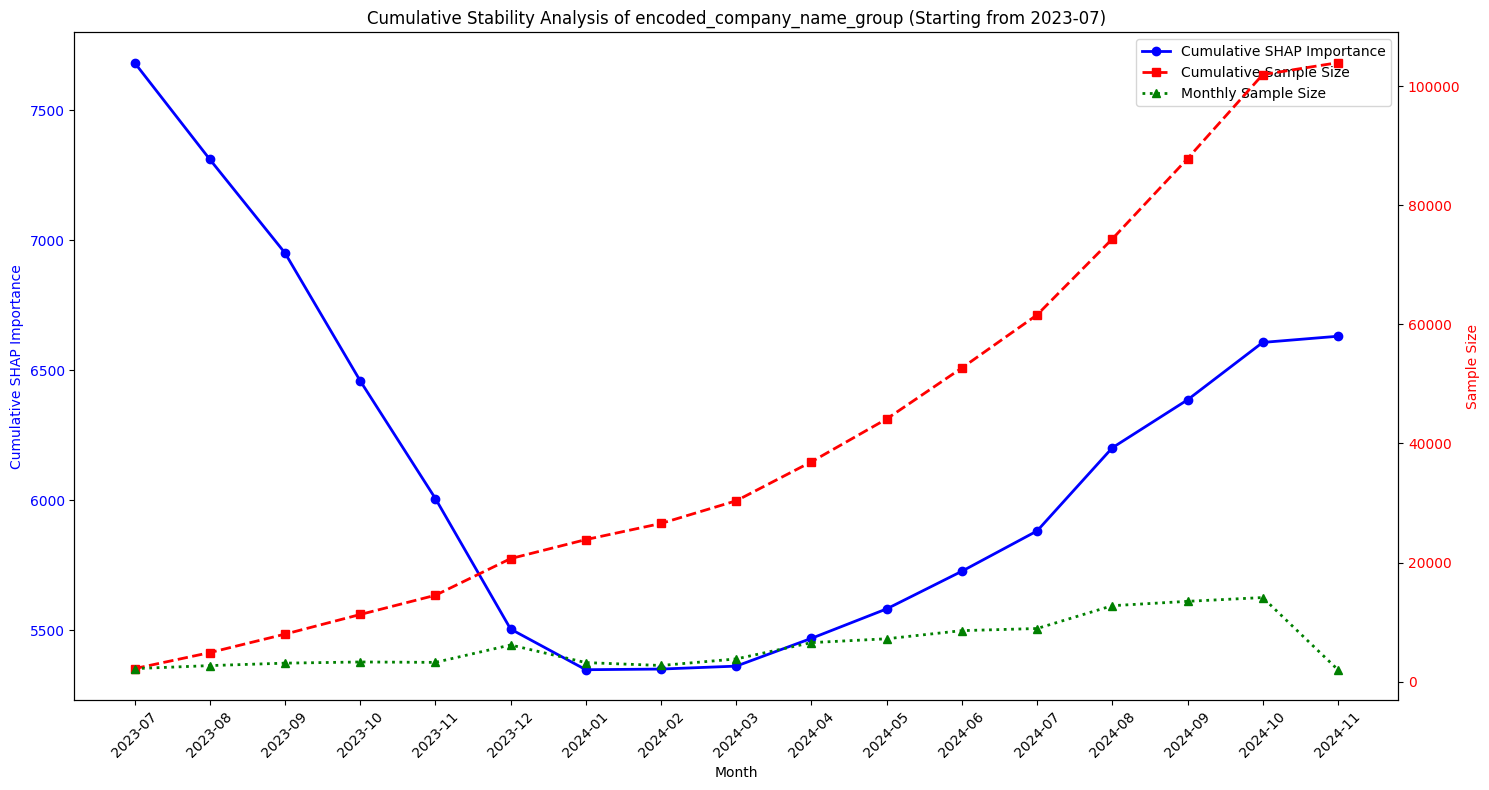


Cumulative Stability Metrics:
final_importance: 6630.8672
importance_change: -1053.0145
std_importance: 721.2881
coefficient_of_variation: 0.1174
max_monthly_change: 502.5467
total_samples: 103926.0000


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
import shap
from datetime import datetime
import tempfile
from google.cloud import storage
from joblib import load
import joblib

def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)
    print(f"Downloaded {source_blob_name} to {destination_file_name}.")

def analyze_cumulative_feature_stability(df, model, feature_name='encoded_company_name_group', 
                                      date_column='decision_date', 
                                      numerical_cols=None, categorical_cols=None,
                                      start_date='2023-07'):
    """
    Analyze the stability of a specific feature's SHAP importance cumulatively from a start date.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing the data
    model : CatBoostRegressor
        Trained CatBoost model
    feature_name : str
        Name of the feature to analyze
    date_column : str
        Name of the column containing dates
    numerical_cols : list
        List of numerical column names
    categorical_cols : list
        List of categorical column names
    start_date : str
        Starting date for cumulative analysis in 'YYYY-MM' format
    """
    
    # Convert date column to datetime if it's not already
    df[date_column] = pd.to_datetime(df[date_column])
    
    # Extract month and year
    df['month_year'] = df[date_column].dt.strftime('%Y-%m')
    
    # Filter data starting from start_date
    start_date = pd.to_datetime(start_date + '-01')
    df = df[df[date_column] >= start_date]
    
    # Initialize SHAP explainer
    explainer = shap.Explainer(model)
    
    # Create storage for cumulative SHAP values
    cumulative_importance = []
    
    # Define the encoder path
    encoded_data_path = "gs://prod-asia-southeast1-tonik-aiml-workspace/Monthly_Income_Estimation/Target_Encoded_Artifacts/companytrgencode.joblib"
    
    # Download and load encoded data once, outside the loop
    with tempfile.NamedTemporaryFile(delete=False, suffix=".joblib") as tmp_encoded_file:
        if encoded_data_path.startswith("gs://"):
            bucket_name = encoded_data_path.split("/")[2]
            source_blob_name = "/".join(encoded_data_path.split("/")[3:])
            download_blob(bucket_name, source_blob_name, tmp_encoded_file.name)
            encoded_data = load(tmp_encoded_file.name)
        else:
            encoded_data = load(encoded_data_path)
    
    # Get sorted unique months
    months = sorted(df['month_year'].unique())
    
    # Process data cumulatively for each month
    for i, current_month in enumerate(months):
        print(f"Processing data through {current_month}...")
        
        # Get cumulative data up to this month
        cumulative_mask = df['month_year'] <= current_month
        cumulative_data = df[cumulative_mask].copy()
        
        # Extract company encoding data
        company_encodings = encoded_data[['loan_company_name', 
                                        'freq_encodedcompanyName', 
                                        'target_encodedcompanyName', 
                                        'encoded_company_name_group']].copy()
        
        df_processed = cumulative_data.copy()
        df_processed = df_processed.merge(company_encodings,
                                        on='loan_company_name',
                                        how='left')
        
        df_processed = df_processed.drop_duplicates(keep='first')
        
        # Fill NaN values with appropriate defaults
        df_processed['freq_encodedcompanyName'] = df_processed['freq_encodedcompanyName'].fillna(0)
        global_mean = encoded_data['target_encodedcompanyName'].mean()
        df_processed['target_encodedcompanyName'] = df_processed['target_encodedcompanyName'].fillna(global_mean)
        df_processed['encoded_company_name_group'] = df_processed['encoded_company_name_group'].fillna(global_mean)
        
        df_processed.drop(columns=['loan_company_name'], 
                         inplace=True, errors='ignore')
        
        cumulative_data = df_processed.copy()
        
        # Prepare features
        X_cumulative = cumulative_data[numerical_cols + categorical_cols]
        
        # Handle categorical features
        for col in categorical_cols:
            X_cumulative[col] = X_cumulative[col].fillna('missing').astype(str)
            
        # Handle numerical features
        for col in numerical_cols:
            X_cumulative[col] = pd.to_numeric(X_cumulative[col], errors='coerce').fillna(0)
        
        # Calculate SHAP values for cumulative data
        shap_values = explainer(X_cumulative)
        
        # Get mean absolute SHAP value for our feature of interest
        feature_idx = X_cumulative.columns.get_loc(feature_name)
        mean_shap = np.abs(shap_values.values[:, feature_idx]).mean()
        
        # Store results
        cumulative_importance.append({
            'month': current_month,
            'shap_importance': mean_shap,
            'cumulative_sample_size': len(cumulative_data),
            'monthly_sample_size': len(df[df['month_year'] == current_month])
        })
    
    # Convert to DataFrame
    cumulative_df = pd.DataFrame(cumulative_importance)
    
    # Create visualization
    plt.figure(figsize=(15, 8))
    
    # Create primary axis for SHAP importance
    ax1 = plt.gca()
    
    # Plot cumulative SHAP importance
    line1 = ax1.plot(cumulative_df['month'], cumulative_df['shap_importance'], 
                     marker='o', linewidth=2, color='blue', label='Cumulative SHAP Importance')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Cumulative SHAP Importance', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Create secondary axis for sample sizes
    ax2 = ax1.twinx()
    line2 = ax2.plot(cumulative_df['month'], cumulative_df['cumulative_sample_size'], 
                     marker='s', linewidth=2, color='red', linestyle='--', 
                     label='Cumulative Sample Size')
    line3 = ax2.plot(cumulative_df['month'], cumulative_df['monthly_sample_size'],
                     marker='^', linewidth=2, color='green', linestyle=':', 
                     label='Monthly Sample Size')
    ax2.set_ylabel('Sample Size', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Add lines to legend
    lines = line1 + line2 + line3
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')
    
    plt.title(f'Cumulative Stability Analysis of {feature_name} (Starting from {start_date.strftime("%Y-%m")})')
    plt.tight_layout()
    plt.show()
    
    # Calculate stability metrics
    stability_metrics = {
        'final_importance': cumulative_df['shap_importance'].iloc[-1],
        'importance_change': cumulative_df['shap_importance'].iloc[-1] - cumulative_df['shap_importance'].iloc[0],
        'std_importance': cumulative_df['shap_importance'].std(),
        'coefficient_of_variation': cumulative_df['shap_importance'].std() / cumulative_df['shap_importance'].mean(),
        'max_monthly_change': np.abs(np.diff(cumulative_df['shap_importance'])).max(),
        'total_samples': cumulative_df['cumulative_sample_size'].iloc[-1]
    }
    
    print("\nCumulative Stability Metrics:")
    for metric, value in stability_metrics.items():
        print(f"{metric}: {value:.4f}")
        
    return cumulative_df, stability_metrics

# Example usage:
if __name__ == "__main__":
    # Load the state file that contains the model and columns information
    state = joblib.load('/home/jupyter/Models/Income_Estimation_Models/Income_Estimation_Model/Beta2WithOutApp_SIL_Quick_1_0_model_good_customer_state_top18SHAP_Step2.joblib')

    # Extract the model, numerical columns, and categorical columns from the state
    model = state['model_top18SHAP']
    numerical_cols = state['numerical_cols_top18SHAP']
    categorical_cols = state['categorical_cols_top18SHAP']

    # Run the cumulative analysis
    cumulative_results, stability_metrics = analyze_cumulative_feature_stability(
        df=df,
        model=model,
        feature_name='encoded_company_name_group',
        numerical_cols=numerical_cols,
        categorical_cols=categorical_cols,
        start_date='2023-07'
    )